Importing Libraries

In [3]:
!pip install photutils #only needed if its being run on colabs
import astropy
import photutils
from astropy.io import fits
from astropy.stats import sigma_clipped_stats,gaussian_sigma_to_fwhm
from astropy.table import QTable
import os

import numpy as np
import os
import matplotlib.pyplot as plt

from photutils.background import LocalBackground, MMMBackground
from photutils.detection import DAOStarFinder
from photutils.psf import IterativePSFPhotometry, IntegratedGaussianPRF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.6 MB/s eta 0:00:00


Loading Files

In [7]:
dir = '/content/sample_data/'
data = fits.open(dir+"ic4756_Blue_0047.fits")
image = data[0].data



Just DAOStarFinder

In [15]:
## Get background
mean, median, std = sigma_clipped_stats(image,sigma=3.0,maxiters=20)
## Find stars
daofind = DAOStarFinder(fwhm=10.0, threshold=4.0*std)  ##peakmax to exclude saturated stars!!
sources = daofind(image - median)
print("     Found %i stars in image " %len(sources))

     Found 81 stars in image 


Text(0, 0.5, 'y (pix)')

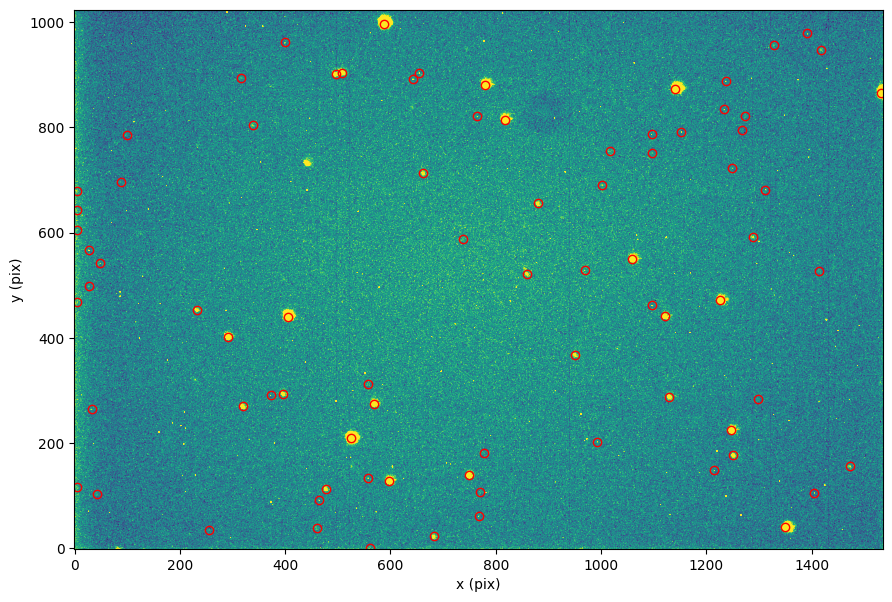

In [16]:
fig = plt.figure(figsize=(12,7))
l1 = np.percentile(image[np.isfinite(image)].flatten(), 1)
l2 = np.percentile(image[np.isfinite(image)].flatten(), 99)
plt.imshow(image,clim=(l1,l2),origin='lower')
plt.plot(sources["xcentroid"],sources["ycentroid"],'or',mfc='none')
plt.xlabel("x (pix)")
plt.ylabel("y (pix)")

In [17]:
nbright = 10
brightest = np.argsort(sources['flux'])[::-1][0:nbright]
brsources = sources[brightest]
print(brsources)

 id     xcentroid          ycentroid      ...  peak         flux                mag        
--- ------------------ ------------------ ... ------ ------------------ -------------------
 81  586.9421916895013  996.3442980766023 ... 3890.0  286.8354194859473  -6.144081946442656
 21  524.3652674840419 209.01729630589907 ... 3759.0 261.92896720319493  -6.045458826254366
 68 1531.8991968294924  864.7038800093961 ... 2855.0 242.18869815755926  -5.960384681840765
 33  404.8073568132553 440.63760108577395 ... 1717.0 122.50881587667169 -5.2204183554009695
 69  1141.260411123091  872.3589491759783 ... 1545.0 110.84344030289874  -5.111774991832192
  5  1350.323393187536  40.67996956202791 ... 1123.0  85.41388124671488  -4.828821142148493
 70  779.9227218631602  880.2530859069827 ...  682.0  52.78253930346144  -4.306225699408516
 64  816.6370000616997  814.3325606205063 ...  560.0  41.89311793598466  -4.055356710881661
 38  1225.484372342234  471.5086425383937 ...  578.0 41.655626656169076  -4.0491

In [18]:
x_init = np.array(brsources['xcentroid'])
y_init = np.array(brsources['ycentroid'])

Iterative PSF Photometry

In [19]:

# PSF is assumed to be a gaussian
psf_model = IntegratedGaussianPRF()

bkgstat = MMMBackground()

localbkg_estimator = LocalBackground(5, 10, bkgstat)


itPSF = IterativePSFPhotometry(psf_model,
                               fit_shape=(5,5),
                               localbkg_estimator=localbkg_estimator,
                               finder=daofind, aperture_radius = 4)

In [20]:


init_params = QTable()
init_params['x'] =x_init
init_params['y'] =y_init
phot = itPSF(image, init_params=init_params)

In [21]:
phot

id,group_id,group_size,iter_detected,local_bkg,x_init,y_init,flux_init,x_fit,y_fit,flux_fit,x_err,y_err,flux_err,npixfit,qfit,cfit,flags
int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64
1,1,1,1,803.3771929824561,586.9421916895013,996.3442980766023,131835.009461719,586.8403458101188,996.161954714463,40986.65038336401,0.19329418476175675,0.19365989942423323,5365.794229670236,25,0.7555580735754011,-0.05294663449803789,0
2,2,1,1,731.3652173913044,524.3652674840419,209.01729630589907,121232.16464030037,524.238219394339,208.67167022500396,39620.50430701776,0.18568901893059822,0.18569890436681122,4973.090643470082,25,0.7128308839699834,-0.044085792453602377,0
3,3,1,1,583.1066666666666,1531.8991968294924,864.7038800093961,112297.49247768632,1531.981182849144,864.6795850182426,33990.70131647116,0.21625774892876326,0.2158739029916383,4968.688252101083,25,0.8390497241561513,-0.05500501816120172,0
4,4,1,1,661.0393013100436,404.8073568132553,440.63760108577395,72615.94095903695,404.8294180418993,440.4125178070093,18971.50755536834,0.17460085814353823,0.17602372983721296,2241.6783680702297,25,0.6851150224049692,-0.03553217936723935,0
5,5,1,1,703.8547008547009,1141.260411123091,872.3589491759783,70675.60053663203,1141.0696297425486,872.1189758034009,15722.059672011359,0.19746906050224952,0.1973185328310895,2100.2311492250783,25,0.770807296132102,-0.052928929353593945,0
6,6,1,1,641.9047619047619,1350.323393187536,40.67996956202791,59905.536698603006,1350.1600347362091,40.6442171287695,12533.52327171975,0.19269078722774063,0.19233298235274407,1630.65080278419,25,0.7658975858390431,-0.049508815479286664,0
7,7,1,1,644.1769911504425,779.9227218631602,880.2530859069827,48892.28881985639,779.8204988548059,880.0973836892856,7554.009774669968,0.1954682171938323,0.19556864925052986,999.5945033621844,25,0.76002072323118,-0.05782346502224774,0
8,8,1,1,634.0521739130436,816.6370000616997,814.3325606205063,45124.059954138436,816.6257947605396,814.1222834049125,6134.819328195241,0.1902552511101078,0.19001008194276736,788.7010081586168,25,0.750292409250421,-0.048859505476201937,0
9,9,1,1,638.8983050847457,1225.484372342234,471.5086425383937,45279.12756353398,1225.312339736283,471.53139341791695,5963.865624622577,0.1978373106225818,0.19754317534868562,795.161975776002,25,0.8078365169462818,-0.04405488774776172,0
